Training CSV files: ['training_benign_labeled.csv', 'training_brute_force_attack_labeled.csv', 'training_ddos_attack_labeled.csv', 'training_gtp_encapsulation_labeled.csv', 'training_gtp_malformed_labeled.csv', 'training_intra_upf_ddos_attack_labeled.csv']
Loading: training_dataset/training_benign_labeled.csv
Loading: training_dataset/training_brute_force_attack_labeled.csv
Loading: training_dataset/training_ddos_attack_labeled.csv
Loading: training_dataset/training_gtp_encapsulation_labeled.csv
Loading: training_dataset/training_gtp_malformed_labeled.csv
Loading: training_dataset/training_intra_upf_ddos_attack_labeled.csv
Combined training shape: (53506, 84)
Removing 17 highly correlated features: ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Packets/s', 'Packet Length Variance', 'PSH Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle M

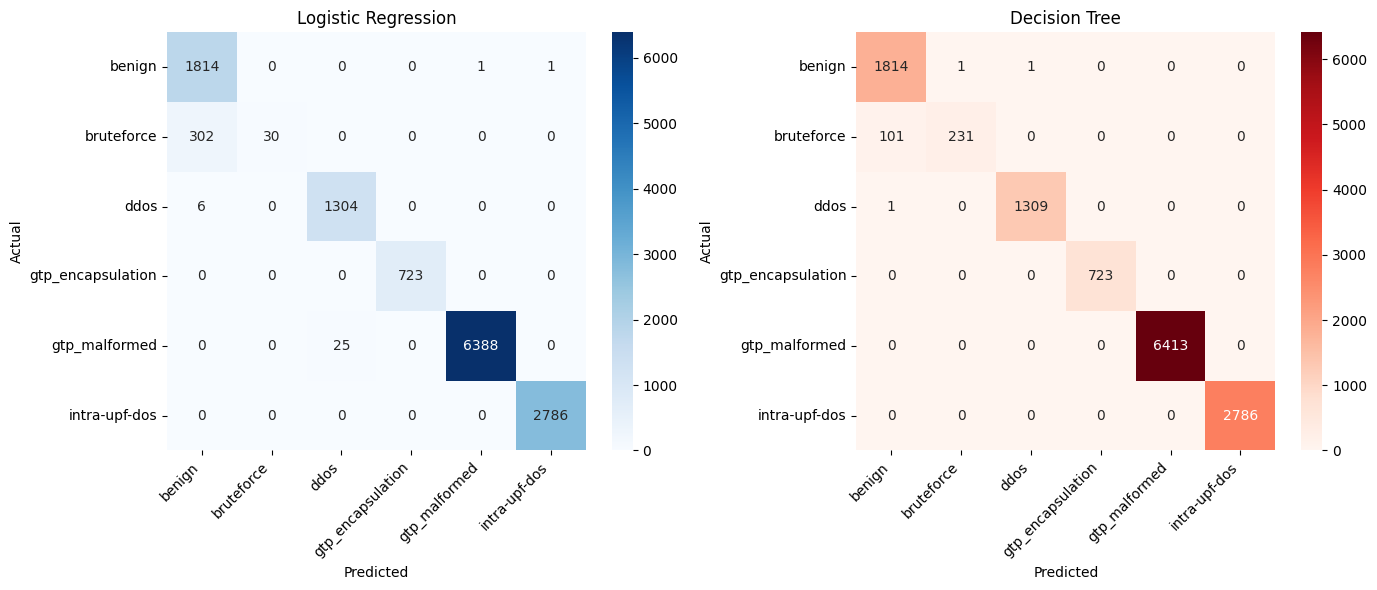


Attack Success Rate (LR): 0.0225
Attack Success Rate (DT): 0.0076


In [12]:
# eval_adversarial_inference.py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------
# Config - adjust as needed
# -----------------------------
training_folder = "training_dataset"
adversarial_folder = "adversarial_dataset"
original_folder = "original_dataset"  # only to infer original file names if needed

# Epsilon to use for the ddos file specifically
eps_for_ddos = "0.1"   # will look for adv_eps_0.1_inference_ddos_attack_labeled.csv

# If no adv file found for some original, fallback to using adv_eps_0_inference_... or original inference file
fallback_eps_patterns = ["0", "0.*"]  # check adv_eps_0_first, adv_eps_0.* etc.

# -----------------------------
# Helper functions
# -----------------------------
def list_csv_files(folder):
    return sorted(f for f in os.listdir(folder) if f.endswith(".csv"))

def remove_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    if to_drop:
        print(f"Removing {len(to_drop)} highly correlated features: {to_drop}")
        return df.drop(columns=to_drop)
    return df

def preprocess_train(df: pd.DataFrame, non_feature_cols=None):
    """Preprocess training df. Returns (X_df, y_ser, X_scaled, y_encoded) and fits encoders/scalers."""
    if non_feature_cols is None:
        non_feature_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'source_file']

    feature_cols = [c for c in df.columns if c not in non_feature_cols + ['Label']]
    X = df[feature_cols].copy()
    y = df['Label'].copy().astype(str).str.strip().str.lower().replace(r'\s+', ' ', regex=True)

    # convert object cols to numeric where possible
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    # Fill numeric missing values with median
    X = X.fillna(X.median(numeric_only=True))

    # Replace infinities
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

    # Remove highly correlated features
    X = remove_highly_correlated_features(X, threshold=0.95)
    feature_names = list(X.columns)

    # Fit label encoder and scaler(s)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    scaler_std = StandardScaler()
    X_scaled = scaler_std.fit_transform(X)

    # Also keep minmax scaler if needed for adversarial generation pipelines
    scaler_minmax = MinMaxScaler()
    X_minmax = scaler_minmax.fit_transform(X)

    return {
        "X_df": X,
        "y": y,
        "X_scaled": X_scaled,
        "y_enc": y_enc,
        "feature_names": feature_names,
        "label_encoder": le,
        "scaler_std": scaler_std,
        "scaler_minmax": scaler_minmax
    }

def preprocess_test(df: pd.DataFrame, preprocess_info, non_feature_cols=None):
    """Preprocess test/adversarial df using training preprocess info. Returns X_df, y_ser, X_scaled, y_enc"""
    if non_feature_cols is None:
        non_feature_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'source_file']

    feature_names = preprocess_info["feature_names"]
    le = preprocess_info["label_encoder"]
    scaler_std = preprocess_info["scaler_std"]
    scaler_minmax = preprocess_info["scaler_minmax"]

    feature_cols = [c for c in df.columns if c not in non_feature_cols + ['Label']]
    X = df[feature_cols].copy()
    y = df['Label'].copy().astype(str).str.strip().str.lower().replace(r'\s+', ' ', regex=True)

    # convert object cols to numeric where possible
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    # Fill missing
    X = X.fillna(X.median(numeric_only=True))
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

    # Add missing features, drop extras, reorder
    missing = set(feature_names) - set(X.columns)
    extra = set(X.columns) - set(feature_names)
    if missing:
        for feat in missing:
            X[feat] = 0
    if extra:
        X = X.drop(columns=list(extra))
    X = X[feature_names]

    # Filter labels unseen in training
    valid_mask = y.isin(list(le.classes_))
    if not valid_mask.all():
        print("Warning: some test labels unseen in training will be removed:", np.unique(y[~valid_mask]))
    X = X.loc[valid_mask].copy()
    y = y.loc[valid_mask].copy()

    y_enc = le.transform(y)
    X_scaled = scaler_std.transform(X)
    X_minmax = scaler_minmax.transform(X)  # if you need minmax

    return {
        "X_df": X,
        "y": y,
        "X_scaled": X_scaled,
        "y_enc": y_enc,
        "X_minmax": X_minmax
    }

# -----------------------------
# 1) Load all training CSVs and train preprocessing & models
# -----------------------------
train_csvs = list_csv_files(training_folder)
if not train_csvs:
    raise RuntimeError(f"No CSVs found in training folder '{training_folder}'")

print("Training CSV files:", train_csvs)

# load and concat
train_dfs = []
for f in train_csvs:
    path = os.path.join(training_folder, f)
    print("Loading:", path)
    df = pd.read_csv(path)
    df = df.drop_duplicates()
    train_dfs.append(df)
train_all = pd.concat(train_dfs, ignore_index=True)
print("Combined training shape:", train_all.shape)

# Preprocess training data: fits encoders/scalers, removes correlated features
prep = preprocess_train(train_all)
feature_names = prep["feature_names"]
label_encoder = prep["label_encoder"]
scaler_std = prep["scaler_std"]
scaler_minmax = prep["scaler_minmax"]

X_train = prep["X_scaled"]
y_train = prep["y_enc"]

# Train classifiers
print("\nTraining Logistic Regression...")
clf_lr = LogisticRegression(max_iter=2000, class_weight=None, random_state=42)
clf_lr.fit(X_train, y_train)

print("Training Decision Tree...")
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

print("Training complete.\n")

# -----------------------------
# 2) Build adversarial inference set per your rule
#    - For file that is ddos_attack_labeled.csv -> adv_eps_{eps_for_ddos}_inference_ddos_attack_labeled.csv
#    - For other files -> adv_eps_0.*_inference_<origfilename> (we prefer eps=0 or 0.*)
# -----------------------------



selected_adv_paths = ['adversarial_dataset/adv_eps_0_inference_benign_labeled.csv',
                      'adversarial_dataset/adv_eps_0.15_inference_brute_force_attack_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_ddos_attack_labeled.csv', ## using eps=0.1 here
                      'adversarial_dataset/adv_eps_0_inference_gtp_encapsulation_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_gtp_malformed_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_intra_upf_ddos_attack_labeled.csv']

# Load and concatenate selected adv files into a single test DataFrame
test_dfs = []
for p in selected_adv_paths:
    print("Loading adversarial test file:", p)
    df = pd.read_csv(p)
    test_dfs.append(df)
test_all = pd.concat(test_dfs, ignore_index=True)
print("Combined adversarial test shape:", test_all.shape)

# -----------------------------
# 3) Preprocess test set using training preprocess info
# -----------------------------
test_prep = preprocess_test(test_all, prep)
X_test = test_prep["X_scaled"]
y_test_enc = test_prep["y_enc"]
y_test_ser = test_prep["y"]

# -----------------------------
# 4) Predict and evaluate both models
# -----------------------------
def evaluate_model(model, X, y_true_enc, le, model_name="model"):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true_enc, y_pred)
    print(f"\n=== Results for {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_true_enc, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true_enc, y_pred)
    return {"acc": acc, "y_pred": y_pred, "cm": cm}

res_lr = evaluate_model(clf_lr, X_test, y_test_enc, label_encoder, "Logistic Regression")
res_dt = evaluate_model(clf_dt, X_test, y_test_enc, label_encoder, "Decision Tree")


# -----------------------------
# Plot confusion matrices side by side
# -----------------------------
def plot_two_cms(cm1, cm2, labels, title1="LR", title2="DT"):
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    sns.heatmap(cm1, annot=True, fmt="d", ax=axes[0], cmap="Blues")
    axes[0].set_title(title1)
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[0].set_xticklabels(labels, rotation=45, ha='right')
    axes[0].set_yticklabels(labels, rotation=0)

    sns.heatmap(cm2, annot=True, fmt="d", ax=axes[1], cmap="Reds")
    axes[1].set_title(title2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    axes[1].set_xticklabels(labels, rotation=45, ha='right')
    axes[1].set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()

plot_two_cms(res_lr["cm"], res_dt["cm"], labels=label_encoder.classes_, title1="Logistic Regression", title2="Decision Tree")

# -----------------------------
# 5) Compute Attack Success Rate (ASR)
#    ASR = fraction of samples that were CORRECT on clean baseline but are INCORRECT under adversarial input.
#    For that we need a clean baseline run on the same rows (if available).
# -----------------------------
# Attempt to build a clean baseline by loading matching eps=0 adv files (or original inference clean files) for the same originals
clean_candidates = ['adversarial_dataset/adv_eps_0_inference_benign_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_brute_force_attack_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_ddos_attack_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_gtp_encapsulation_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_gtp_malformed_labeled.csv',
                      'adversarial_dataset/adv_eps_0_inference_intra_upf_ddos_attack_labeled.csv']


if clean_candidates:
    clean_dfs = [pd.read_csv(p) for p in clean_candidates]
    clean_all = pd.concat(clean_dfs, ignore_index=True)
    clean_prep = preprocess_test(clean_all, prep)
    X_clean = clean_prep["X_scaled"]
    y_clean_enc = clean_prep["y_enc"]

    # Predictions on clean
    y_pred_clean_lr = clf_lr.predict(X_clean)
    y_pred_clean_dt = clf_dt.predict(X_clean)

    # Compute ASR on samples that were correct on clean
    def compute_asr(y_true, pred_clean, pred_adv):
        correct_mask = (pred_clean == y_true)
        if correct_mask.sum() == 0:
            return np.nan
        now_incorrect = (pred_adv != y_true) & correct_mask
        return now_incorrect.sum() / correct_mask.sum()

    asr_lr = compute_asr(y_clean_enc, y_pred_clean_lr, res_lr["y_pred"])
    asr_dt = compute_asr(y_clean_enc, y_pred_clean_dt, res_dt["y_pred"])
    print(f"\nAttack Success Rate (LR): {asr_lr:.4f}")
    print(f"Attack Success Rate (DT): {asr_dt:.4f}")
else:
    print("\nNo clean (eps=0) files found to compute ASR baseline. You can compute ASR relative to model predictions on the clean inference set if you saved it separately.")

# -----------------------------
# End
# -----------------------------
